In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## This Notebook Demonstrates:
1. Reading the data in python, preparing it for analysis, and adjusting the labels to contain underscores
2. The code that simplfies a Raw drawing to the Simplified drawing
3. How to make a submission file with predictions in the required format

In [ ]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:

# !mkdir -p drive
# !google-drive-ocamlfuse drive
import os
os.chdir("drive/MyDrive/Colab Notebooks") # to where your code and "input_my" are

In [3]:



import numpy as np 
import pandas as pd 

print(os.listdir("./input_my")) #####
print(os.listdir("./input_my/train")) #####

['test_ans.csv', 'demo.csv', 'res.csv', 'train_raw', 'train']
['rabbit.csv', 'shoe.csv', 'scissors.csv', 'star.csv', 'sword.csv', 'The_Eiffel_Tower.csv', 'tree.csv', 'airplane.csv', 'bee.csv', 'bicycle.csv', 'butterfly.csv', 'cake.csv', 'bird.csv', 'cat.csv', 'camera.csv', 'chair.csv', 'clock.csv', 'computer.csv', 'diamond.csv', 'door.csv', 'ear.csv', 'hamburger.csv', 'guitar.csv', 'hat.csv', 'hammer.csv', 'hand.csv', 'ladder.csv', 'lion.csv', 'leaf.csv', 'pencil.csv']


In [4]:
import warnings
warnings.filterwarnings('ignore') # to suppress some matplotlib deprecation warnings

import ast
import math

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Model training

In [5]:

import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
!python -m pip install dask[bag]
from dask import bag

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

     |████████████████████████████████| 102kB 8.6MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4042 sha256=2276336fd6d05c6f6baee3bfb0abb8fd0cfb0a9cacb4818977e0b6ce82db0b02
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket


In [6]:
class_paths = glob('./input_my/train/*.csv') #####
numstonames = {i: v[17:-4].replace(" ", "_") for i, v in enumerate(class_paths)} # v[14:-4]
print(numstonames)
namestonums = {v:k for k,v in numstonames.items()}

num_classes = 30
imheight, imwidth = 64, 64  
ims_per_class = 3000 # 2000

def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.


{0: 'rabbit', 1: 'shoe', 2: 'scissors', 3: 'star', 4: 'sword', 5: 'The_Eiffel_Tower', 6: 'tree', 7: 'airplane', 8: 'bee', 9: 'bicycle', 10: 'butterfly', 11: 'cake', 12: 'bird', 13: 'cat', 14: 'camera', 15: 'chair', 16: 'clock', 17: 'computer', 18: 'diamond', 19: 'door', 20: 'ear', 21: 'hamburger', 22: 'guitar', 23: 'hat', 24: 'hammer', 25: 'hand', 26: 'ladder', 27: 'lion', 28: 'leaf', 29: 'pencil'}


In [7]:
train_grand = []

for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c,nrows = ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())
    trainarray = np.reshape(trainarray, (train.shape[0], -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
#less memory than np.concatenate
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


In [9]:
train_grand.shape

(90000, 4097)

In [10]:
# valfrac = 0.1
# cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[:, 0], train_grand[:, 1:]

del train_grand

valid = pd.read_csv('./input_my/res.csv',nrows = ims_per_class*30) ##### ./input/valid.csv #### res
imagebag = bag.from_sequence(valid.drawing.values).map(draw_it)
validarray = np.array(imagebag.compute())
validarray = np.reshape(validarray, (validarray.shape[0], imheight, imwidth, 1))



X_val = validarray
y_val = [namestonums[w.replace(" ", "_") ] for w in valid.word]

del valid

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

In [17]:
y_val.shape

(500, 30)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0.]


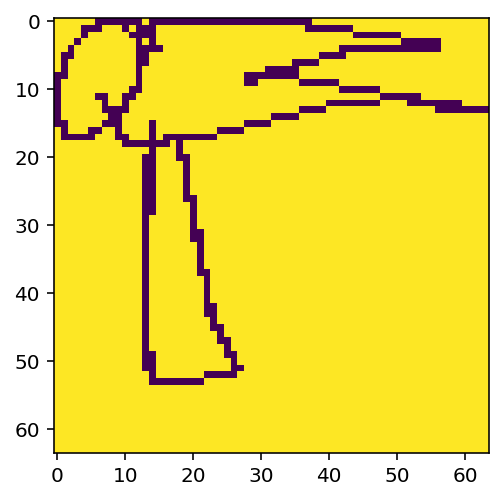

In [19]:
import matplotlib.pyplot as plt
print(y_val[0,:])
plt.imshow(X_val[0,:,:,0])
plt.show()

In [20]:
import seaborn as sns

In [21]:

valid = pd.read_csv('./input_my/res.csv',nrows = ims_per_class*3) ##### ./input/valid.csv #### res
Y_train = valid["word"]
Y_train.value_counts()

chair               32
hat                 29
hand                28
hamburger           23
diamond             22
sword               20
tree                20
shoe                19
bird                19
bicycle             19
cake                18
guitar              18
rabbit              17
The Eiffel Tower    17
ear                 16
bee                 16
leaf                15
clock               14
airplane            14
lion                13
star                13
pencil              13
butterfly           13
ladder              12
door                12
scissors            11
camera              11
hammer              10
cat                  8
computer             8
Name: word, dtype: int64

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 680)               1

In [ ]:
import time
starttime = time.time()

In [ ]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)
endtime = time.time()

Epoch 1/22
2813/2813 [==============================] - 32s 9ms/step - loss: 1.3204 - accuracy: 0.6308 - top_3_accuracy: 0.7887 - val_loss: 0.4455 - val_accuracy: 0.8727 - val_top_3_accuracy: 0.9598
Epoch 2/22
2813/2813 [==============================] - 24s 8ms/step - loss: 0.4809 - accuracy: 0.8589 - top_3_accuracy: 0.9569 - val_loss: 0.3552 - val_accuracy: 0.8973 - val_top_3_accuracy: 0.9692
Epoch 3/22
2813/2813 [==============================] - 24s 8ms/step - loss: 0.3385 - accuracy: 0.8975 - top_3_accuracy: 0.9754 - val_loss: 0.3235 - val_accuracy: 0.9064 - val_top_3_accuracy: 0.9733
Epoch 4/22
2813/2813 [==============================] - 24s 8ms/step - loss: 0.2520 - accuracy: 0.9207 - top_3_accuracy: 0.9846 - val_loss: 0.3250 - val_accuracy: 0.9070 - val_top_3_accuracy: 0.9734
Epoch 5/22
2813/2813 [==============================] - 24s 8ms/step - loss: 0.1921 - accuracy: 0.9408 - top_3_accuracy: 0.9906 - val_loss: 0.3106 - val_accuracy: 0.9130 - val_top_3_accuracy: 0.9753
Epoch

## Model prediction

In [ ]:
# test = pd.read_csv('./input_my/demo.csv')[['drawing']]
# imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
# testarray = np.array(imagebag.compute())
# testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
# testpreds = model.predict(testarray, verbose=0)
# ttvs = np.argsort(-testpreds)
# print(ttvs)


In [ ]:
# print(ttvs)

In [ ]:
# print(numstonames)
# for idx in ttvs[:,[0,1,2]]:
#     print(idx[0])
#     print(numstonames[idx[0]])
#     print(numstonames[idx[1]])
#     print(numstonames[idx[2]])
#     print('----------')

## Preprocessing the generating data and predict

In [ ]:
# threshold = 0.5

# graph = pd.read_csv('input/output.csv',header=None)
# grapharray = np.array(graph)
# grapharray = np.where(grapharray[:] > threshold,1,0)
# grapharray = np.reshape(grapharray, (1,imheight, imwidth, 1))
# graphpreds = model.predict(grapharray, verbose=0)
# gvs = np.argsort(-graphpreds)


# for idx in gvs[:]:
#     for i in idx:
#         print(numstonames[i])



## Save model

In [ ]:
model.save('my_model_1219.h5')

## Making a Submission

In [ ]:
test = pd.read_csv('./input_my/test_ans.csv')[['drawing']]
imagebag = bag.from_sequence(test.drawing.values).map(draw_it)
testarray = np.array(imagebag.compute())
testarray = np.reshape(testarray, (testarray.shape[0], imheight, imwidth, 1))
testpreds = model.predict(testarray, verbose=0)
ttvs = np.argsort(-testpreds)



predict_label = [numstonames[ttvs[i][0]] for i in range(ttvs.shape[0])]

# test['word'] = predict_label
# test.to_csv('test_predict.csv')

In [ ]:
predict_label

['ladder',
 'airplane',
 'rabbit',
 'hat',
 'hat',
 'shoe',
 'door',
 'leaf',
 'hand',
 'diamond',
 'ear',
 'ear',
 'tree',
 'airplane',
 'chair',
 'tree',
 'clock',
 'butterfly',
 'sword',
 'ear',
 'ear',
 'hammer',
 'hat',
 'clock',
 'butterfly',
 'diamond',
 'hat',
 'hamburger',
 'sword',
 'ear',
 'clock',
 'cat',
 'guitar',
 'bicycle',
 'hat',
 'lion',
 'sword',
 'chair',
 'sword',
 'clock',
 'hamburger',
 'butterfly',
 'bicycle',
 'pencil',
 'cat',
 'hamburger',
 'shoe',
 'airplane',
 'pencil',
 'diamond',
 'chair',
 'hat',
 'bicycle',
 'bee',
 'camera',
 'hat',
 'bicycle',
 'hammer',
 'cat',
 'camera',
 'rabbit',
 'ear',
 'door',
 'door',
 'leaf',
 'computer',
 'hand',
 'diamond',
 'camera',
 'bicycle',
 'bee',
 'pencil',
 'star',
 'hat',
 'hand',
 'ear',
 'chair',
 'The_Eiffel_Tower',
 'bird',
 'bird',
 'camera',
 'cake',
 'chair',
 'rabbit',
 'hamburger',
 'pencil',
 'clock',
 'butterfly',
 'camera',
 'butterfly',
 'door',
 'door',
 'clock',
 'ear',
 'cat',
 'hammer',
 'sword',

In [ ]:
test = pd.read_csv('./input_my/test_ans.csv')[['word']] #####
count = 0
hit = 0
for i in range(len(test['word'])):
  count +=1
  if test['word'][i] == predict_label[i]:
    hit +=1
print("hit rate = %d/%d"%(hit,count))

hit rate = 174/200


In [ ]:
182/200

0.91